In [1]:
# Load Libraries

import pandas as pd
import numpy as np
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import os
from os.path import join, isfile
# Set a seed value
seed_value= 12345
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)


In [2]:
## TBI data loading


In [3]:
print(os.path.expanduser('~'))
print(os.getcwd())
# Load and Check Data
if os.name == 'nt':
    general_p = Path('Z:/TBI Sleep/')
elif os.name == 'posix':
    general_p = Path('/mnt/z/TBI Sleep/')
Data_path = general_p / "Pilot_data"/ "Preprocessed" / "level_2" 
feature_path = general_p / Data_path / "dt_all.csv"
#feature_path = str(general + "/ANNE Validation/Sleep Study Stroke Validation/Data/Data_Archive/SSV_FeatureMatrix_06112021.csv")

data = pd.read_csv(feature_path, sep=',')
#data = pd.read_csv(r"Z:\SIESTA\ANNE Validation\Sleep Study Stroke Validation\Data\FeatureMatrix_040621.csv", sep=',')
data = data.replace(-np.inf, np.nan)
data = data.fillna(0)
data.head()
# Label and Code Sleep Stage Variables

# Filter out stages labelled 'L' meaning the lights were still on
#-----------------------------------------------------------------------
# data = data[data.psg_stage != 'L'] # No longer applicable
#-----------------------------------------------------------------------
data = data.rename({'stg': 'psg_stage'}, axis=1)
data = data.rename({'sub': 'subject'}, axis=1)

# Code sleep stage variables
#-----------------------------------------------------------------------
# 4 stage; wake vs. light sleep (NREM1 and NREM2) vs. deep sleep (NREM3) vs. REM sleep
stage4_conditions = [
    (data['psg_stage'] == 'W'),
    (data['psg_stage'] == 'N1') | (data['psg_stage'] == 'N2'),
    (data['psg_stage'] == 'N3'),
    (data['psg_stage'] == 'R')]
stage4_values = [0, 1, 2, 3] # 4 stage code
data['stage4_code'] = np.select(stage4_conditions, stage4_values) # new column with 4 stage code

# 3 stage; wake vs. NREM sleep (NREM1, NREM2, NREM3) vs. REM sleep
stage3_conditions = [
    (data['psg_stage'] == 'W'),
    (data['psg_stage'] == 'N1') | (data['psg_stage'] == 'N2') | (data['psg_stage'] == 'N3'),
    (data['psg_stage'] == 'R')]
stage3_values = [0, 1, 2] # 3 stage code
data['stage3_code'] = np.select(stage3_conditions, stage3_values) # new column with 3 stage code

# 2 stage; wake vs. sleep (NREM1, NREM2, NREM3, REM)
stage2_conditions = [
    (data['psg_stage'] == 'W'),
    (data['psg_stage'] == 'N1') | (data['psg_stage'] == 'N2') | (data['psg_stage'] == 'N3') | (data['psg_stage'] == 'R')]
stage2_values = [0, 1] # 2 stage code
data['stage2_code'] = np.select(stage2_conditions, stage2_values) # new column with 2 stage code
#-----------------------------------------------------------------------


# Add names for sleep stage variables
#-----------------------------------------------------------------------
# 4 stage; wake vs. light sleep (NREM1 and NREM2) vs. deep sleep (NREM3) vs. REM sleep
stage4char_conditions = [
    (data['psg_stage'] == 'W'),
    (data['psg_stage'] == 'N1') | (data['psg_stage'] == 'N2'),
    (data['psg_stage'] == 'N3'),
    (data['psg_stage'] == 'R')]
stage4char_values = ['Wake', 'Light', 'Deep', 'REM'] # 4 stage code
data['stage4_char'] = np.select(stage4char_conditions, stage4char_values) # new column with 4 stage code

# 3 stage; wake vs. NREM sleep (NREM1, NREM2, NREM3) vs. REM sleep
stage3char_conditions = [
    (data['psg_stage'] == 'W'),
    (data['psg_stage'] == 'N1') | (data['psg_stage'] == 'N2') | (data['psg_stage'] == 'N3'),
    (data['psg_stage'] == 'R')]
stage3char_values = ['Wake', 'NREM', 'REM'] # 3 stage code
data['stage3_char'] = np.select(stage3char_conditions, stage3char_values) # new column with 3 stage code

# 2 stage; wake vs. sleep (NREM1, NREM2, NREM3, REM)
stage2char_conditions = [
    (data['psg_stage'] == 'W'),
    (data['psg_stage'] == 'N1') | (data['psg_stage'] == 'N2') | (data['psg_stage'] == 'N3') | (data['psg_stage'] == 'R')]
stage2char_values = ['Wake', 'Sleep'] # 2 stage code
data['stage2_char'] = np.select(stage2char_conditions, stage2char_values) # new column with 2 stage code
#-----------------------------------------------------------------------

data.head(10)
print(data.shape)

# Filter Data

# Filter Sleep Stage Transition Epochs
# Function to remove the epoch before and after a sleep stage transition
#-------------------------------------------------------------------------------
def transition_stages_rm(df_rm):
    data_rm = df_rm.loc[df_rm["psg_stage"].shift(-1) == df_rm["psg_stage"]]
    data_rm = data_rm.loc[data_rm["psg_stage"].shift(1) == data_rm["psg_stage"]]
    return data_rm
# groupby subject to apply the function
data_rm = data.groupby('subject', group_keys=False).apply(transition_stages_rm)
#-------------------------------------------------------------------------------

# Filter Signals
# Replace RR values with median value
#-------------------------------------------------------------------------------
data_rm['NNmean'] = data_rm['NNmean'].replace(0,data_rm['NNmean'].median())
#data_rm['RR_min'] = data_rm['RR_min'].replace(0,data_rm['RR_min'].median())
#data_rm['RR_max'] = data_rm['RR_max'].replace(0,data_rm['RR_max'].median())

# Remove zeroes
#-------------------------------------------------------------------------------
data_zero_rm = data_rm[data_rm.spo2 > 50]
data_zero_rm = data_zero_rm[data_rm.NNmean > 0]
data_zero_rm = data_zero_rm[data_rm.lfhf > 0]
data_zero_rm = data_zero_rm[data_rm.HR_vital > 40]

#-------------------------------------------------------------------------------


print(data_zero_rm.shape)
data_zero_rm = data_zero_rm.reset_index()
data_zero_rm
data_zero_rm.head(10)

# save
#data_save_p = general_p / Data_path / "Data_Archive"/"Adam_Feature_zrm.csv"
#data_zero_rm.to_csv(data_save_p, index = False)
                        
                        
                        

/home/pchen02
/mnt/z/TBI Sleep/code/TBI_HRV
(5819, 108)
(3151, 108)


,index,Time.X.Min,Time.X.Max,Time.X.Mean,Time.X.Standard Deviation,Time.X.Correlation XY,Time.X.Correlation XZ,Time.X.Correlation YZ,Time.X.Median Crossings,Time.X.25th Percentile,...,chest_temp,limb_temp,posture,subject,stage4_code,stage3_code,stage2_code,stage4_char,stage3_char,stage2_char
0,1,-0.945,0.699,-0.285,0.314,-0.483,-0.698,0.461,41,-0.531,...,29.906267,29.047350,1,TBI_1,0,0,0,Wake,Wake,Wake
1,2,-0.844,0.738,-0.567,0.311,-0.309,-0.328,0.895,38,-0.754,...,30.098900,29.046117,1,TBI_1,0,0,0,Wake,Wake,Wake
2,6,-1.113,0.371,-0.297,0.297,-0.230,-0.499,0.403,36,-0.563,...,30.780233,29.292983,1,TBI_1,0,0,0,Wake,Wake,Wake
3,7,-0.973,-0.703,-0.869,0.044,0.476,-0.204,0.658,85,-0.898,...,30.889933,29.750850,1,TBI_1,0,0,0,Wake,Wake,Wake
4,8,-0.984,0.254,-0.324,0.439,-0.310,-0.973,0.403,19,-0.824,...,30.975133,30.273883,1,TBI_1,0,0,0,Wake,Wake,Wake
5,9,-0.070,0.090,0.063,0.018,0.189,-0.014,0.336,265,0.063,...,31.037400,30.717367,1,TBI_1,0,0,0,Wake,Wake,Wake
6,10,-0.984,0.402,-0.122,0.287,-0.370,-0.784,0.607,7,-0.254,...,31.101567,31.051700,1,TBI_1,0,0,0,Wake,Wake,Wake
7,13,-1.078,0.281,-0.557,0.272,0.257,-0.177,0.581,61,-0.742,...,31.246267,32.054633,1,TBI_1,0,0,0,Wake,Wake,Wake
8,15,-0.047,0.051,-0.012,0.012,0.086,0.370,0.044,151,-0.020,...,31.368033,32.244133,1,TBI_1,0,0,0,Wake,Wake,Wake
9,16,-0.051,0.023,-0.017,0.009,-0.234,-0.080,0.142,263,-0.023,...,31.427600,32.370167,1,TBI_1,0,0,0,Wake,Wake,Wake


In [4]:
#-------------------------------------------------------------------------------
# Feature Modality Lists
#-------------------------------------------------------------------------------
data_zero_rm['condition'] = 'TBI'
df_subject_TBI = data_zero_rm[['subject']] # need this in the feature list for grouping purposes
df_subject_TBI = df_subject_TBI.loc[df_subject_TBI['subject'] != 'TBI_6']
# df_subject = df_subject.loc[df_subject['subject'] != 'SSV_006']
data_zero_rm = data_zero_rm.loc[data_zero_rm['subject'] != 'TBI_6']
# data_zero_rm = data_zero_rm.loc[data_zero_rm['subject'] != 'SSV_006']


df_ecg_TBI = data_zero_rm[['NNmean', 'NNmedian', 'NNmode', 'NNvariance', 'NNskew', 'NNkurt', 'NNiqr', 'SDNN', 'RMSSD',
                       'pnn50', 'pnn20', 'btsdet', 'avgsqi', 'atc', 'ulf', 'vlf', 'lf', 'hf', 'lfhf', 'ttlpwr',
                       'SD1', 'SD2', 'SD1SD2', 'ApEn']]

df_condition_TBI = data_zero_rm[['condition']]


df_acc = data_zero_rm[['Time.X.Min', 'Time.X.Max', 'Time.X.Mean', 'Time.X.Standard Deviation', 'Time.X.Correlation XY',
                        'Time.X.Correlation XZ', 'Time.X.Median Crossings',
                        'Time.Y.Min', 'Time.Y.Max', 'Time.Y.Mean', 'Time.Y.Standard Deviation',
                        'Time.Y.Correlation XY', 'Time.Y.Correlation YZ', 'Time.Y.Median Crossings',
                        'Time.Z.Min', 'Time.Z.Max', 'Time.Z.Mean',
                        'Time.Z.Standard Deviation', 'Time.Z.Correlation XZ', 'Time.Z.Correlation YZ',
                        'Time.Z.Median Crossings',
                        'Time.Vector Magnitude.Min', 'Time.Vector Magnitude.Max', 'Time.Vector Magnitude.Mean',
                        'Time.Vector Magnitude.Standard Deviation', 
                        'Time.Vector Magnitude.Median Crossings', 'Time.Vector Magnitude.25th Percentile',
                        'Time.Vector Magnitude.75th Percentile', 'Frequency.X.Dominant Frequency',
                        'Frequency.X.Dominant Frequency Magnitude', 'Frequency.Y.Dominant Frequency',
                        'Frequency.Y.Dominant Frequency Magnitude', 'Frequency.Z.Dominant Frequency',
                        'Frequency.Z.Dominant Frequency Magnitude', 'Frequency.Vector Magnitude.Dominant Frequency',
                        'Frequency.Vector Magnitude.Dominant Frequency Magnitude']]



#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Labels for Iterations at Different Stage Resolutions
#-------------------------------------------------------------------------------
labels_stage = {'Min':['Wake','Sleep'],
                'Med':['Wake','NREM','REM'],
                'Max':['Wake','Light','Deep','REM']}

labels_class = {'Min':[0,1],
                'Med':[0,1,2],
                'Max':[0,1,2,3]}

stages = {'Min':'stage2_code',
          'Med':'stage3_code',
          'Max':'stage4_code'}

classBreakdown = {'Min':2,
                  'Med':3,
                  'Max':4}

resolution_label = {'Min': '2 Stage',
                    'Med': '3 Stage',
                    'Max': '4 Stage'}
#-------------------------------------------------------------------------------

In [5]:
data_zero_rm.columns

Index(['index', 'Time.X.Min', 'Time.X.Max', 'Time.X.Mean',
       'Time.X.Standard Deviation', 'Time.X.Correlation XY',
       'Time.X.Correlation XZ', 'Time.X.Correlation YZ',
       'Time.X.Median Crossings', 'Time.X.25th Percentile',
       ...
       'limb_temp', 'posture', 'subject', 'stage4_code', 'stage3_code',
       'stage2_code', 'stage4_char', 'stage3_char', 'stage2_char',
       'condition'],
      dtype='object', length=110)

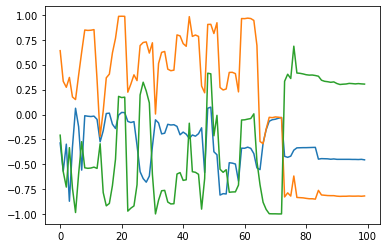

In [6]:
# Graph Actigraph 
import matplotlib.pyplot as plt
plt.plot(data_zero_rm.iloc[0:100,]['Time.X.Mean'])
plt.plot(data_zero_rm.iloc[0:100,]['Time.Y.Mean'])
plt.plot(data_zero_rm.iloc[0:100,]['Time.Z.Mean'])
plt.show()

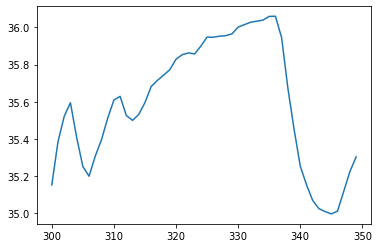

In [7]:
# Graph Temperature
import matplotlib.pyplot as plt
plt.plot(data_zero_rm.iloc[300:350,]['limb_temp'])
plt.show()

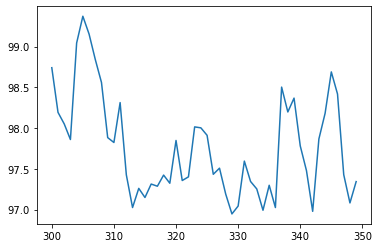

In [8]:
# Graph Temperature
import matplotlib.pyplot as plt
plt.plot(data_zero_rm.iloc[300:350,]['spo2'])
plt.show()

In [9]:
del data
del data_zero_rm
del data_rm

In [10]:
#Healthy data loading

In [11]:
# Load and Check Data
#general = "/Volumes/RTO/SIESTA"
#general = "Z:/SIESTA/ANNE Validation/shhs"
general = "/mnt/z/SIESTA/ANNE Validation/shhs/"
import os
import re
ls_sub = os.listdir(str(general + "/preprocessed/level_2/ECG/"))
ls_sub_sao2 = os.listdir(str(general + "/preprocessed/level_2/SaO2_parquet/"))
ls_sub.sort(key=lambda f: re.sub('\D', '', f))
ls_sub.remove('.DS_Store')
ls_sub.remove('HRV_all.csv')
ls_nsub = [
    n.split('-')[1]
    for n in ls_sub
]

ls_nsub_sao2 = [
    n.split('.')[0]
    for n in ls_sub_sao2
]

In [12]:
ls_sub_sao2_new = list()
for element in ls_nsub_sao2:
    if element in ls_nsub:
        ls_sub_sao2_new.append(element)
ls_final = list()
for element in ls_nsub:
    if element in ls_sub_sao2_new:
        ls_final.append(element)

appended_data = []
appended_data = pd.DataFrame(appended_data)
appended_stages = []
appended_mismatch = []

In [13]:

#append_missing = []
# The current method assume that the starting of stage scores equal to the start of ECG and SaO2 recording. 
# I align these data by the starting point. 
for i in range(0,len(ls_final),1):
    subID = ls_final[i]
#subID = "shhs1-200001"
#feature_path = str(general + "/ANNE Validation/Sleep Study Stroke Validation/Data/Data_Archive/SSV_FeatureMatrix_06112021.csv")
    #sub_feature_path = str(general + "/preprocessed/level_2/ECG/shhs1-" + subID + "/HRV_results_allwindows.csv")
    sub_feature_path = str(general + "/preprocessed/level_2/ECG/shhs1-" + subID + "/HRV_results_allwindows.parquet")
    #sub_SaO2_path = str(general + "/preprocessed/level_2/SaO2_csv/" + subID + ".csv")
    sub_SaO2_path = str(general + "/preprocessed/level_2/SaO2_parquet/" + subID + ".parquet")
    #data = pd.read_csv(sub_feature_path, sep=',')
    data = pd.read_parquet(sub_feature_path)
    data['patID'] = subID
    #data.astype('float16')
    stages_dt = pd.read_csv(str(general + "/preprocessed/level_1/shhs1-" + subID + "_stages.csv"))
    stages_dt = stages_dt.rename({'Stages': 'psg_stage'}, axis=1)  # rename stages to psg_stages to fit with prior codings
    stages_dt['psg_stage'] = stages_dt['psg_stage'].astype(str)
    #sao2_dt = pd.read_csv(sub_SaO2_path)
    sao2_dt = pd.read_parquet(sub_SaO2_path)
    #stages_dt['patID'] = subID
    sao2_dt = sao2_dt.drop('index', axis=1)
    # dt_missing = pd.DataFrame(
    #         {"subID":[str(subID)],
    #         "data_count":[str(data_new.shape[0])],
    #         "missing_count":[data_new[data_new['tdflag'] != 5].shape[0]]
    #          }
    #         )
    # data_new = data_new.dropna
    
    data_new = pd.concat([data,sao2_dt, stages_dt], axis = 1)
    #data_new = data_new.dropna()
    del data
    del stages_dt
    del sao2_dt
    appended_data = pd.concat([appended_data,data_new],axis = 0, ignore_index = True)
    del data_new




In [14]:
data_zero_rm = appended_data[appended_data['lfhf'].notna()]
data_zero_rm = data_zero_rm[data_zero_rm['mean'].notna()]


In [15]:
# Label and Code Sleep Stage Variables

# Code sleep stage variables
#-----------------------------------------------------------------------
# 4 stage; wake vs. light sleep (NREM1 and NREM2) vs. deep sleep (NREM3) vs. REM sleep
def stage_code_label(data):
    stage4_conditions = [
        (data['psg_stage'] == '0'),
        (data['psg_stage'] == '1') | (data['psg_stage'] == '2'),
        (data['psg_stage'] == '3') | (data['psg_stage'] == '4'),
        (data['psg_stage'] == '5')]
    stage4_values = [0, 1, 2, 3] # 4 stage code
    data['stage4_code'] = np.select(stage4_conditions, stage4_values) # new column with 4 stage code

    # 3 stage; wake vs. NREM sleep (NREM1, NREM2, NREM3) vs. REM sleep
    stage3_conditions = [
        (data['psg_stage'] == '0'),
        (data['psg_stage'] == '1') | (data['psg_stage'] == '2') | (data['psg_stage'] == '3') | (data['psg_stage'] == '4'),
        (data['psg_stage'] == '5')]
    stage3_values = [0, 1, 2] # 3 stage code
    data['stage3_code'] = np.select(stage3_conditions, stage3_values) # new column with 3 stage code

    # 2 stage; wake vs. sleep (NREM1, NREM2, NREM3, REM)
    stage2_conditions = [
        (data['psg_stage'] == '0'),
        (data['psg_stage'] == '1') | (data['psg_stage'] == '2') |
        (data['psg_stage'] == '3') | (data['psg_stage'] == '4') | (data['psg_stage'] == '5')]
    stage2_values = [0, 1] # 2 stage code
    data['stage2_code'] = np.select(stage2_conditions, stage2_values) # new column with 2 stage code
    #-----------------------------------------------------------------------


    # Add names for sleep stage variables
    #-----------------------------------------------------------------------
    # 4 stage; wake vs. light sleep (NREM1 and NREM2) vs. deep sleep (NREM3) vs. REM sleep
    stage4char_conditions = [
        (data['psg_stage'] == '0'),
        (data['psg_stage'] == '1') | (data['psg_stage'] == '2'),
        (data['psg_stage'] == '3') | (data['psg_stage'] == '4'), 
        (data['psg_stage'] == '5')]
    stage4char_values = ['Wake', 'Light', 'Deep', 'REM'] # 4 stage code
    data['stage4_char'] = np.select(stage4char_conditions, stage4char_values) # new column with 4 stage code

    # 3 stage; wake vs. NREM sleep (NREM1, NREM2, NREM3) vs. REM sleep
    stage3char_conditions = [
        (data['psg_stage'] == '0'),
        (data['psg_stage'] == '1') | (data['psg_stage'] == '2') | (data['psg_stage'] == '3') | (data['psg_stage'] == '4'),
        (data['psg_stage'] == '5')]
    stage3char_values = ['Wake', 'NREM', 'REM'] # 3 stage code
    data['stage3_char'] = np.select(stage3char_conditions, stage3char_values) # new column with 3 stage code

    # 2 stage; wake vs. sleep (NREM1, NREM2, NREM3, REM)
    stage2char_conditions = [
        (data['psg_stage'] == '0'),
        (data['psg_stage'] == '1') | (data['psg_stage'] == '2') | (data['psg_stage'] == '3') |
        (data['psg_stage'] == '4') | (data['psg_stage'] == '5')]
    stage2char_values = ['Wake', 'Sleep'] # 2 stage code
    data['stage2_char'] = np.select(stage2char_conditions, stage2char_values) # new column with 2 stage code
    #-----------------------------------------------------------------------
stage_code_label(data_zero_rm)

In [16]:
data_zero_rm['condition'] = 'healthy'
# =============================================== Select 10 subjects
selected_sub = ['200023', '200115', '200032', '200101' ]
# selected_sub = ['200001', '200002', '200003', '200004', '200005', '200006',
#        '200007', '200008', '200009', '200010']
data_selected = data_zero_rm.loc[data_zero_rm['patID'] .isin(selected_sub)]
df_subject = data_selected[['patID']] # need this in the feature list for grouping purposes
df_subject_healthy = df_subject.rename({'patID': 'subject'}, axis=1)
df_ecg_healthy = data_selected[['NNmean', 'NNmedian', 'NNmode', 'NNvariance', 'NNskew', 'NNkurt', 'NNiqr', 'SDNN', 'RMSSD',
                       'pnn50', 'pnn20', 'btsdet', 'avgsqi', 'atc', 'ulf', 'vlf', 'lf', 'hf', 'lfhf', 'ttlpwr',
                       'SD1', 'SD2', 'SD1SD2', 'ApEn']]
df_condition_healthy = data_selected[['condition']]


In [17]:
del data
del data_rm
del data_zero_rm

NameError: name 'data' is not defined

In [18]:
# Combine healthy data and TBI data
df_subject_all = pd.concat([df_subject_healthy,df_subject_TBI],axis = 0, ignore_index = True)
df_ecg_all = pd.concat([df_ecg_healthy,df_ecg_TBI], axis = 0, ignore_index = True)

In [19]:
df_subject_all.subject.unique()

array(['200023', '200032', '200101', '200115', 'TBI_1', 'TBI_2', 'TBI_3',
       'TBI_5'], dtype=object)

In [20]:
df_condition_all = pd.concat([df_condition_healthy,df_condition_TBI], axis = 0, ignore_index = True)

In [21]:
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def tsne_graph(df_ecg, df_ppg):
    data_tsne = pd.concat([df_ecg, df_ppg], axis = 1)

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data_tsne)

In [22]:
data_tsne = df_ecg_all
data_tsne = data_tsne.dropna()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [23]:
tsne_results = tsne.fit_transform(data_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5734 samples in 0.001s...
[t-SNE] Computed neighbors for 5734 samples in 0.561s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5734
[t-SNE] Computed conditional probabilities for sample 2000 / 5734
[t-SNE] Computed conditional probabilities for sample 3000 / 5734
[t-SNE] Computed conditional probabilities for sample 4000 / 5734
[t-SNE] Computed conditional probabilities for sample 5000 / 5734
[t-SNE] Computed conditional probabilities for sample 5734 / 5734
[t-SNE] Mean sigma: 70.611938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.203583
[t-SNE] KL divergence after 300 iterations: 1.681187


In [24]:
general_p = Path('/mnt/z/TBI Sleep/')
save_path = general_p / "Pilot_data"/ "Preprocessed" / "tsne_graph" 

In [25]:
data_tsne['tsne-2d-one'] = tsne_results[:,0]
data_tsne['tsne-2d-two'] = tsne_results[:,1]
os.chdir(str(save_path))
os.getcwd()

'/mnt/z/TBI Sleep/Pilot_data/Preprocessed/tsne_graph'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


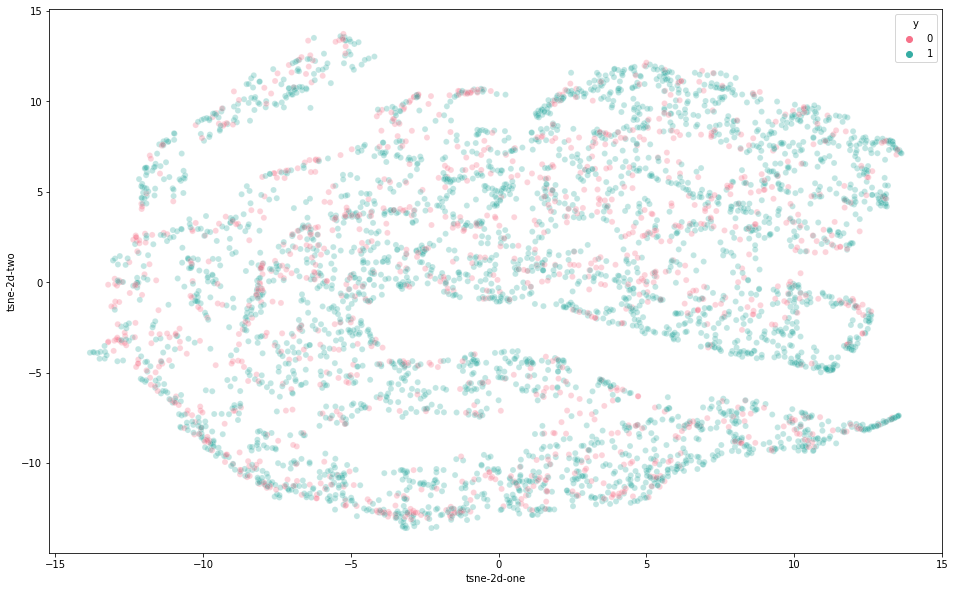

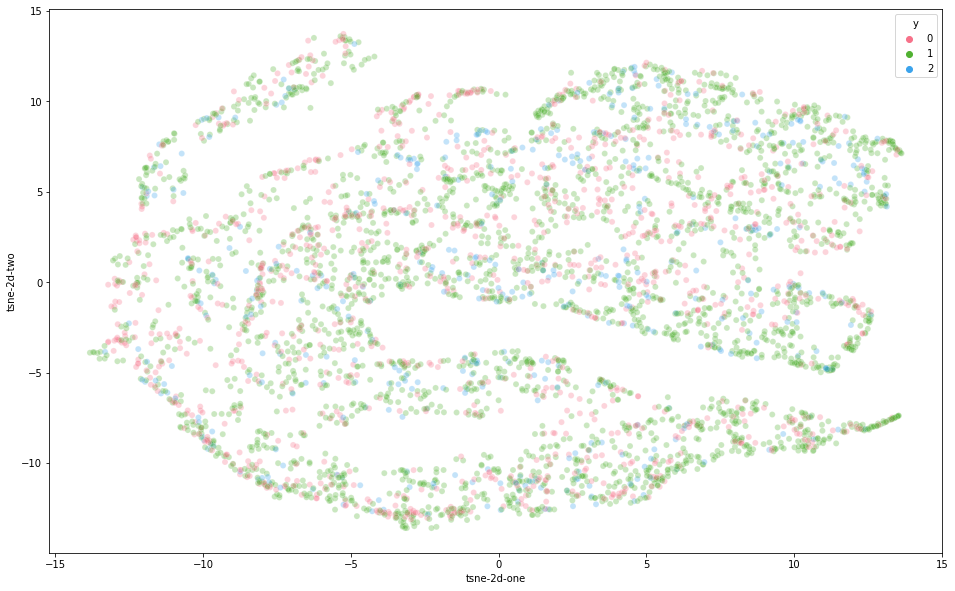

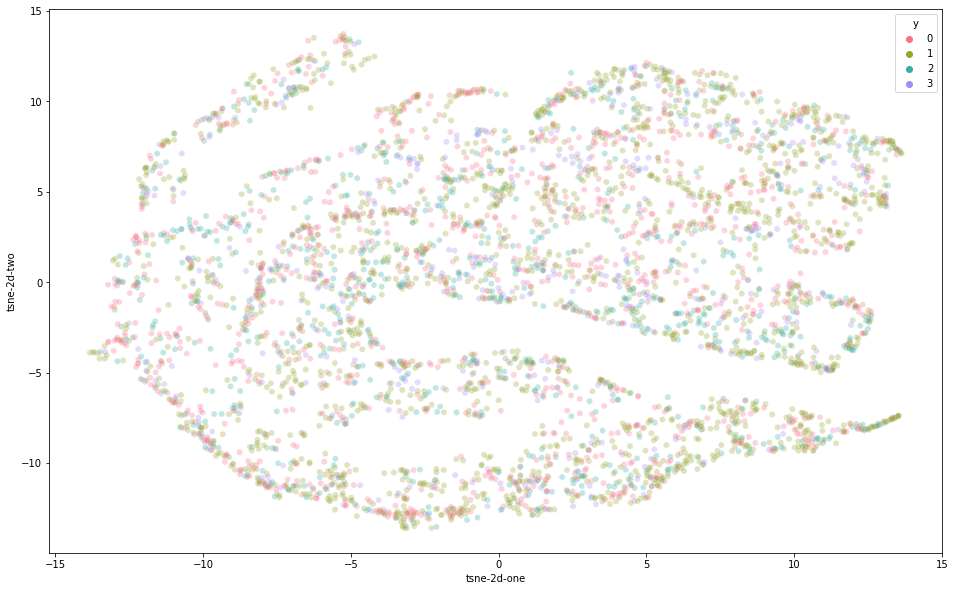

In [30]:
for res in ['Min', 'Med', 'Max']:
    data_tsne['y'] = data_zero_rm[stages[res]].astype('category')
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("husl", classBreakdown[res] ),
        data=data_tsne,
        legend="full",
        alpha=0.3
    )
    #plt.savefig(str(resolution_label[res] + "_tsne_category.png"), dpi = 1080)
    plt.savefig(str(resolution_label[res] + "_tsne_category.eps"), format='eps')

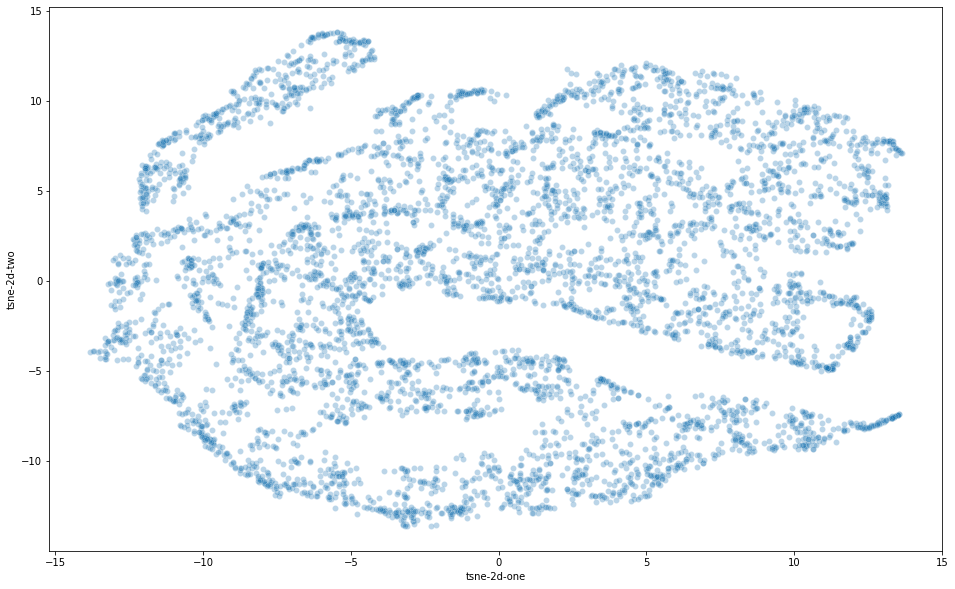

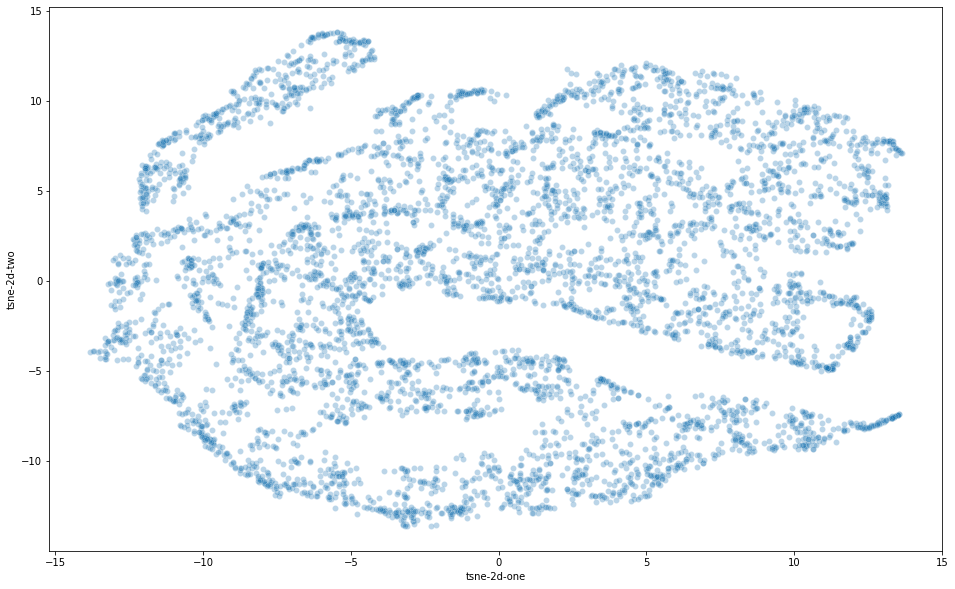

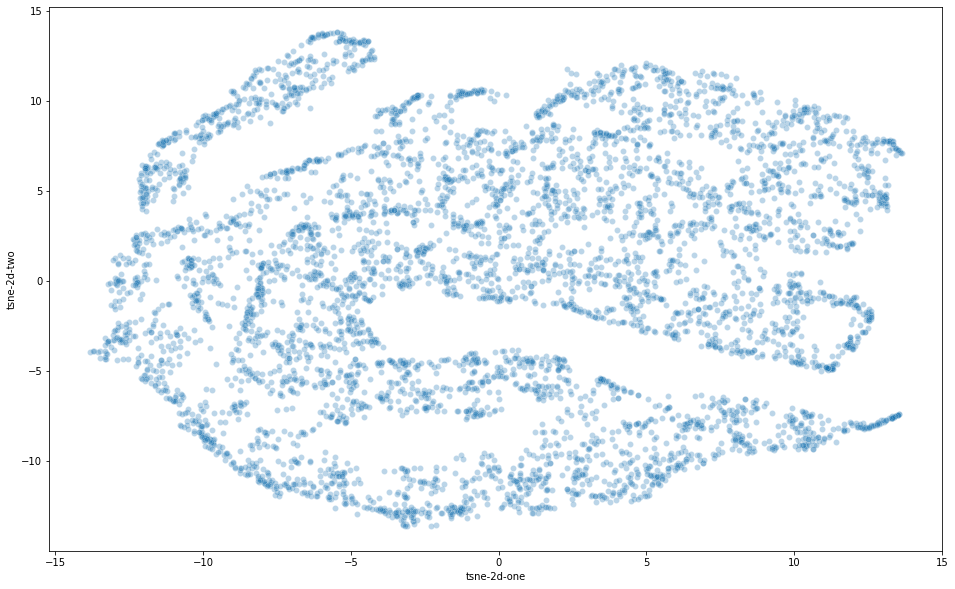

In [29]:
for res in ['Min', 'Med', 'Max']:
    data_tsne['y'] = data_selected[stages[res]].astype('category')
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("husl", int(classBreakdown[res]) ),
        data=data_tsne,
        legend="full",
        alpha=0.3
    )
    plt.savefig(str(resolution_label[res] + "_tsne_category.png"), dpi = 1080)

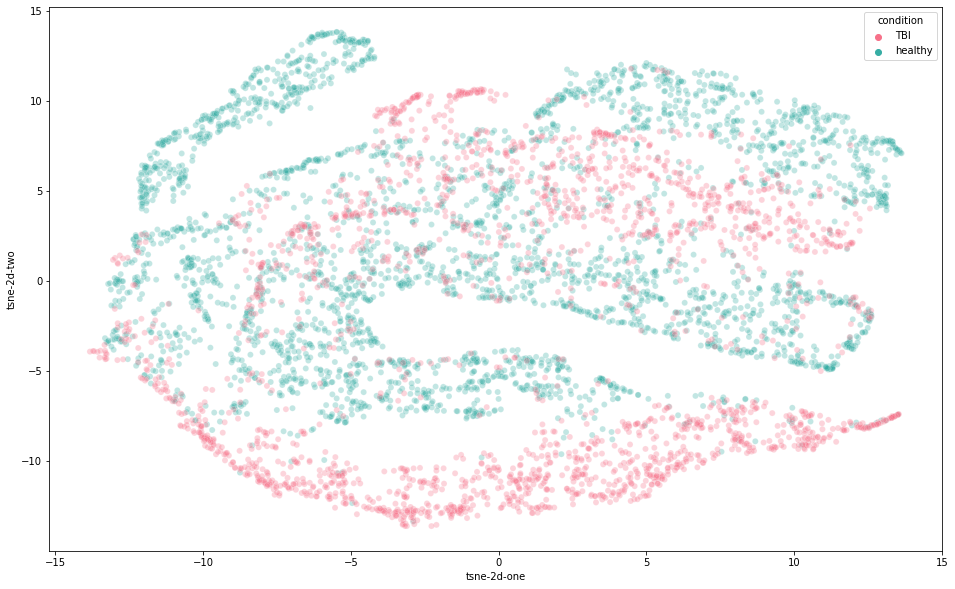

In [36]:
data_tsne['condition'] = df_condition_all['condition'].astype('category')
sub_ls = data_tsne.condition.unique()
data_tsne['condition'] = df_condition_all['condition'].astype('category')
plt.figure(figsize=(16,10))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="condition",
        palette=sns.color_palette("husl",len(sub_ls)),
        data=data_tsne,
        legend="full",
        alpha=0.3
    )
plt.savefig(str("tsne_condition.png"), dpi = 1080)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


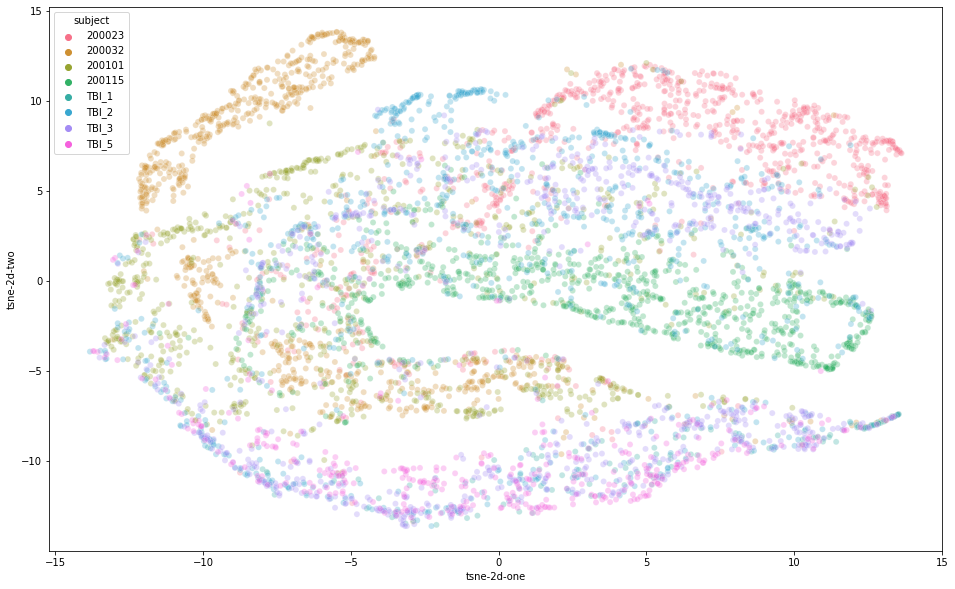

In [32]:
data_tsne['subject'] = df_subject_all['subject'].astype('category')
sub_ls = data_tsne.subject.unique()

plt.figure(figsize=(16,10))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="subject",
        palette=sns.color_palette("husl",len(sub_ls)),
        data=data_tsne,
        legend="full",
        alpha=0.3
    )
#plt.savefig(str(resolution_label[res] + "_tsne_subject.png"), dpi = 1080)
plt.savefig(str(resolution_label[res] + "_tsne_subject.eps"), format='eps')

In [47]:
selected_sub = ['200023', '200115', '200032', '200101' ]
df_subject_all['TBI_health'] = np.where(df_subject_all['subject'].isin(selected_sub)
                                         , 'healthy',  df_subject_all['subject'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


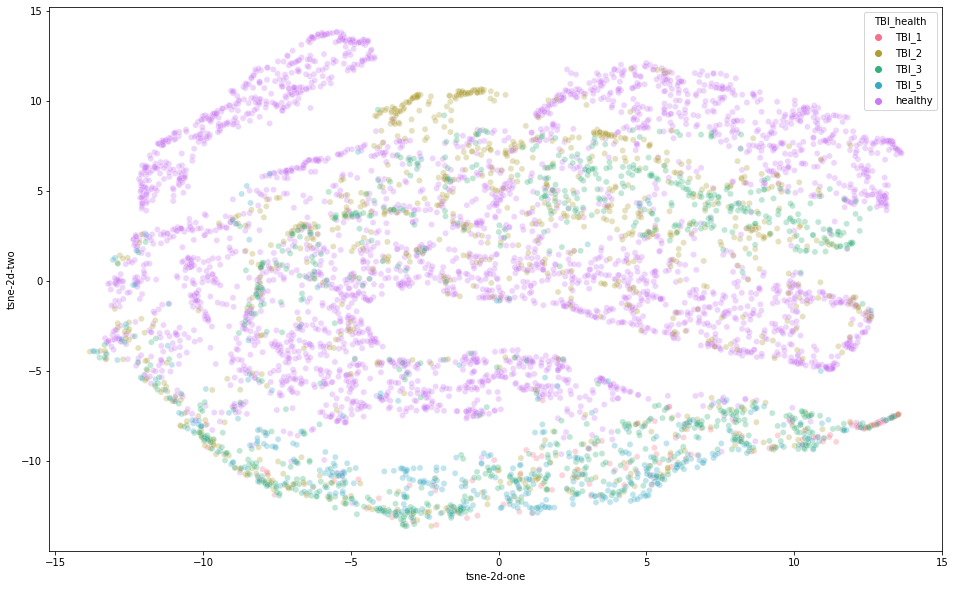

In [53]:
data_tsne['TBI_health'] = df_subject_all['TBI_health'].astype('category')
sub_ls = data_tsne.TBI_health.unique()
data_tsne['TBI_health'] = df_subject_all['TBI_health'].astype('category')
plt.figure(figsize=(16,10))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="TBI_health",
        palette=sns.color_palette("husl",len(sub_ls)),
        data=data_tsne,
        legend="full",
        alpha=0.3
    )
#plt.savefig(str(resolution_label[res] + "_tsne_subject.png"), dpi = 1080)
plt.savefig(str(resolution_label[res] + "_tsne_TBI_health.eps"), format='eps')

In [ ]:
# Load stroke data

In [ ]:
# # Load and Check Data
# general = "/home/pchen02/RTO/SIESTA"
# #feature_path = str(general + "/ANNE Validation/Sleep Study Stroke Validation/Data/Data_Archive/SSV_FeatureMatrix_06112021.csv")
# feature_path = str(general + "/ANNE Validation/Sleep Study Stroke Validation/Data/Data_Archive/FeatureMatrix_040621.csv")
# data = pd.read_csv(feature_path, sep=',')
# #data = pd.read_csv(r"Z:\SIESTA\ANNE Validation\Sleep Study Stroke Validation\Data\FeatureMatrix_040621.csv", sep=',')
# data = data.replace(-np.inf, np.nan)
# data = data.fillna(0)
# data.head()



In [ ]:
# # Label and Code Sleep Stage Variables

# # Filter out stages labelled 'L' meaning the lights were still on
# #-----------------------------------------------------------------------
# data = data[data.psg_stage != 'L']
# #-----------------------------------------------------------------------


# # Code sleep stage variables
# #-----------------------------------------------------------------------
# # 4 stage; wake vs. light sleep (NREM1 and NREM2) vs. deep sleep (NREM3) vs. REM sleep
# stage4_conditions = [
#     (data['psg_stage'] == 'W'),
#     (data['psg_stage'] == '1') | (data['psg_stage'] == '2'),
#     (data['psg_stage'] == '3'),
#     (data['psg_stage'] == 'R')]
# stage4_values = [0, 1, 2, 3] # 4 stage code
# data['stage4_code'] = np.select(stage4_conditions, stage4_values) # new column with 4 stage code

# # 3 stage; wake vs. NREM sleep (NREM1, NREM2, NREM3) vs. REM sleep
# stage3_conditions = [
#     (data['psg_stage'] == 'W'),
#     (data['psg_stage'] == '1') | (data['psg_stage'] == '2') | (data['psg_stage'] == '3'),
#     (data['psg_stage'] == 'R')]
# stage3_values = [0, 1, 2] # 3 stage code
# data['stage3_code'] = np.select(stage3_conditions, stage3_values) # new column with 3 stage code

# # 2 stage; wake vs. sleep (NREM1, NREM2, NREM3, REM)
# stage2_conditions = [
#     (data['psg_stage'] == 'W'),
#     (data['psg_stage'] == '1') | (data['psg_stage'] == '2') | (data['psg_stage'] == '3') | (data['psg_stage'] == 'R')]
# stage2_values = [0, 1] # 2 stage code
# data['stage2_code'] = np.select(stage2_conditions, stage2_values) # new column with 2 stage code
# #-----------------------------------------------------------------------


# # Add names for sleep stage variables
# #-----------------------------------------------------------------------
# # 4 stage; wake vs. light sleep (NREM1 and NREM2) vs. deep sleep (NREM3) vs. REM sleep
# stage4char_conditions = [
#     (data['psg_stage'] == 'W'),
#     (data['psg_stage'] == '1') | (data['psg_stage'] == '2'),
#     (data['psg_stage'] == '3'),
#     (data['psg_stage'] == 'R')]
# stage4char_values = ['Wake', 'Light', 'Deep', 'REM'] # 4 stage code
# data['stage4_char'] = np.select(stage4char_conditions, stage4char_values) # new column with 4 stage code

# # 3 stage; wake vs. NREM sleep (NREM1, NREM2, NREM3) vs. REM sleep
# stage3char_conditions = [
#     (data['psg_stage'] == 'W'),
#     (data['psg_stage'] == '1') | (data['psg_stage'] == '2') | (data['psg_stage'] == '3'),
#     (data['psg_stage'] == 'R')]
# stage3char_values = ['Wake', 'NREM', 'REM'] # 3 stage code
# data['stage3_char'] = np.select(stage3char_conditions, stage3char_values) # new column with 3 stage code

# # 2 stage; wake vs. sleep (NREM1, NREM2, NREM3, REM)
# stage2char_conditions = [
#     (data['psg_stage'] == 'W'),
#     (data['psg_stage'] == '1') | (data['psg_stage'] == '2') | (data['psg_stage'] == '3') | (data['psg_stage'] == 'R')]
# stage2char_values = ['Wake', 'Sleep'] # 2 stage code
# data['stage2_char'] = np.select(stage2char_conditions, stage2char_values) # new column with 2 stage code
# #-----------------------------------------------------------------------

# data.head(10)
# print(data.shape)

In [ ]:
# # Filter Data

# # Filter Sleep Stage Transition Epochs
# # Function to remove the epoch before and after a sleep stage transition
# #-------------------------------------------------------------------------------
# def transition_stages_rm(df_rm):
#     data_rm = df_rm.loc[df_rm["stage4_code"].shift(-1) == df_rm["stage4_code"]]
#     data_rm = data_rm.loc[data_rm["stage4_code"].shift(1) == data_rm["stage4_code"]]
#     return data_rm
# # groupby subject to apply the function
# data_rm = data.groupby('subject', group_keys=False).apply(transition_stages_rm)
# #-------------------------------------------------------------------------------

# # Filter Signals
# # Replace RR values with median value
# #-------------------------------------------------------------------------------
# data_rm['RR_mean'] = data_rm['RR_mean'].replace(0,data_rm['RR_mean'].median())
# data_rm['RR_min'] = data_rm['RR_min'].replace(0,data_rm['RR_min'].median())
# data_rm['RR_max'] = data_rm['RR_max'].replace(0,data_rm['RR_max'].median())